# Random Forest Model: Best Method

Links to the other notebooks:

CS M148 Project Preprocessing: https://colab.research.google.com/drive/18ze2QgG8UeXuplGR0lq5VfGLEeEaUTts?usp=sharing

CS M148 Project Exploratory Analysis: https://colab.research.google.com/drive/1sA-ax1z6zLOVfNR756jP41mUsWfAyjAA?usp=sharing

CS M148 Linear Regression: https://colab.research.google.com/drive/1UWBN2hL9WuzW6QXH-DHdR4h6AYs7geCA?usp=sharing

CS M148 Project Logistic Regression: https://colab.research.google.com/drive/1QnawgURNDzJR9TIJYYKsuW47LopmuGWg?usp=sharing

CS M148 Project PCA and Clustering: https://colab.research.google.com/drive/1lvnPTYh8F7-HDpgLVozCWA8oyp4KmUpi?usp=sharing

CS M148 Project Neural Network: https://colab.research.google.com/drive/1GnEirq2E0rr5yikiFCn1gCalTtFKqRvL?usp=sharing


In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score


# Loading Training and Test Dataset

In [ ]:
# Training_balanced_embed is our training dataset that has the embeddings applied to it with balancing to the classes
training_embed = pd.read_csv("balanced_training_embed.csv")

# Test_embed is the given test data from Hugging Face with embeddings added to it
test_embed = pd.read_csv("valid_embed.csv")

In [ ]:
def parse_space_embeddings(df, col_name):
    return np.vstack([
        np.array(x.strip("[]").split(), dtype=float)
        for x in df[col_name].values
    ])

X_train = parse_space_embeddings(training_embed, "financialBERT_embedding")
y_train = training_embed["label"].values.ravel()

X_test = parse_space_embeddings(test_embed, "financialBERT_embedding")
y_test = test_embed["label"].values.ravel()

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (5365, 768)
X_test shape: (2388, 768)


#**Training the Random Forest Algorithm**


We are using a Random Search for our random forest hyperparameters and also the number of PCA components we should use. The RandomizedSearchCV uses a 10-Fold Cross Validation.

In [ ]:

pipeline = Pipeline([
    ('pca', PCA()),
    ('rf', RandomForestClassifier(n_jobs=-1))
])

param_grid = {
    'pca__n_components': [50, 75, 100, 125, 150],
    'rf__n_estimators': [200, 400, 600, 800],
    'rf__max_depth': [3, 5, 8, 10],
    'rf__min_samples_split': [50, 100, 300],
    'rf__min_samples_leaf': [50, 100, 300],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__ccp_alpha': [1e-4, 1e-5, 1e-6],
    'rf__class_weight': [None, 'balanced']
}

rand_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1_macro',
    cv=10,
    verbose=2,
    n_jobs=-1,
    refit=True
)

rand_search.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('rf',
                                              RandomForestClassifier(n_jobs=-1))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'pca__n_components': [50, 75, 100, 125,
                                                              150],
                                        'rf__ccp_alpha': [0.0001, 1e-05, 1e-06],
                                        'rf__class_weight': [None, 'balanced'],
                                        'rf__max_depth': [3, 5, 8, 10],
                                        'rf__max_features': ['sqrt', 'log2'],
                                        'rf__min_samples_leaf': [50, 100, 300],
                                        'rf__min_samples_split': [50, 100, 300],
                                        'rf__n_estimators': [200, 400, 600,
                                                             800]},
                   scoring='f1_macro', verbose=2)

In [ ]:
best_rf = rand_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Best hyperparameters found:")
print(rand_search.best_params_)

print("\nClassification report on test set:")
print(classification_report(y_test, y_pred))

rf = rand_search.best_estimator_

Best hyperparameters found:
{'rf__n_estimators': 400, 'rf__min_samples_split': 300, 'rf__min_samples_leaf': 100, 'rf__max_features': 'log2', 'rf__max_depth': 10, 'rf__class_weight': 'balanced', 'rf__ccp_alpha': 0.0001, 'pca__n_components': 150}

Classification report on test set:
              precision    recall  f1-score   support

           0       0.44      0.67      0.53       347
           1       0.53      0.64      0.58       475
           2       0.87      0.72      0.79      1566

    accuracy                           0.69      2388
   macro avg       0.61      0.67      0.63      2388
weighted avg       0.74      0.69      0.71      2388



Best hyperparameters that were found:

'rf__n_estimators': 400

'rf__min_samples_split': 300

'rf__min_samples_leaf': 100

'rf__max_features': log2

'rf__max_depth': 10

'rf__class_weight': balanced

'rf__ccp_alpha': 0.0001

'pca__n_components': 150

#**Calculating Confusion Matrix and Evaluation Metrics Using Testing Data**




In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

y_train_pred = rf.predict(X_train)
cm = confusion_matrix(y_train, y_train_pred)
cm_df = pd.DataFrame(cm,
                     index=['Observed 0', 'Observed 1', 'Observed 2'],
                     columns=['Predicted 0', 'Predicted 1', 'Predicted 2'])

accuracy = accuracy_score(y_train, y_train_pred)
error_rate = 1 - accuracy
f1 = f1_score(y_train, y_train_pred, average='weighted')

print("Confusion Matrix:\n", cm_df)
print(f"Prediction Accuracy: {accuracy:.4f}")
print(f"Prediction Error: {error_rate:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))

cm = confusion_matrix(y_train, y_train_pred)
labels = [0, 1, 2]

tpr_dict = {}
tnr_dict = {}

for i, cls in enumerate(labels):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # recall
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0  # specificity

    tpr_dict[cls] = TPR
    tnr_dict[cls] = TNR

print("TPR (recall) per class:", tpr_dict)
print("TNR (specificity) per class:", tnr_dict)




Confusion Matrix:
             Predicted 0  Predicted 1  Predicted 2
Observed 0         1063          173          206
Observed 1          273         1329          321
Observed 2          208          221         1571
Prediction Accuracy: 0.7387
Prediction Error: 0.2613
F1 Score: 0.7385

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.74      0.71      1442
           1       0.77      0.69      0.73      1923
           2       0.75      0.79      0.77      2000

    accuracy                           0.74      5365
   macro avg       0.74      0.74      0.74      5365
weighted avg       0.74      0.74      0.74      5365

TPR (recall) per class: {0: np.float64(0.7371705963938974), 1: np.float64(0.6911076443057722), 2: np.float64(0.7855)}
TNR (specificity) per class: {0: np.float64(0.8773897527402498), 1: np.float64(0.8855316676350958), 2: np.float64(0.8433878157503715)}


#**Calculating ROC Curve and AUC On Testing Data**



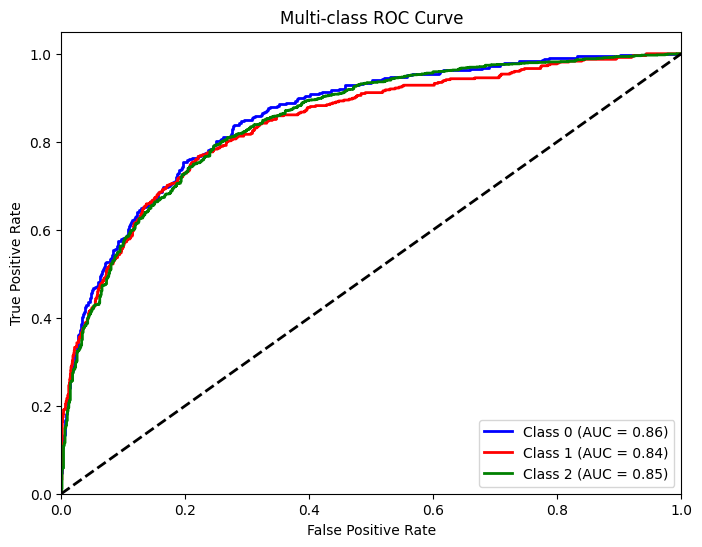

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

Y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = Y_test_bin.shape[1]

y_score = rf.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(
        Y_test_bin[:, i],
        y_score[:,1]

        if isinstance(y_score[i], np.ndarray) and y_score[i].ndim>1 else y_score[:, i]
    )
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()